#This notebook explores diamond prices from the tutorial below
https://www.datacamp.com/tutorial/adam-optimizer-tutorial


###We develop a small neural network to study the distribution of weights and biases, through changing the loss function

In [ ]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:

np.random.seed(4)
# Load the diamonds dataset
diamonds = sns.load_dataset("diamonds")
dataset_size = 5000
xy = diamonds[["carat", "price"]].values
np.random.shuffle(xy)  # Shuffle the data
xy = xy[:dataset_size]

# Normalize the data
mean = np.mean(xy, axis=0)
std = np.std(xy, axis=0)
xy_normalized = (xy - mean) / std

# Split the data
train_size = int(0.8 * dataset_size)
train_xy, test_xy = xy_normalized[:train_size], xy_normalized[train_size:]

# Convert to PyTorch tensors
train_x = torch.tensor(train_xy[:, 0], dtype=torch.float32).view(-1, 1)
train_y = torch.tensor(train_xy[:, 1], dtype=torch.float32).view(-1, 1)
test_x = torch.tensor(test_xy[:, 0], dtype=torch.float32).view(-1, 1)
test_y = torch.tensor(test_xy[:, 1], dtype=torch.float32).view(-1, 1)

# Define the Predictor network, for this section we do not inlcude an interval estimator network (You can change this as necessary)

class Predictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 32)
        self.fc_out = nn.Linear(32, 1)  # Final prediction layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        return self.fc_out(x)

# Initialize models
predictor = Predictor()

# Adam optimizer parameters
learning_rate_pred = 1e-5
epochs = 2500
batch_size = 32
#beta1 You can set these gradient parameters as needed
#beta2

#We compute standard mean square loss function here
def mse_loss(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)

# Storage dictionaries for weights and biases
L2_weights = {f"fc{i+1}": [] for i in range(6)}
L2_weights["fc_out"] = []

L2_biases = {f"fc{i+1}": [] for i in range(6)}
L2_biases["fc_out"] = []

def adam_optimization():
    optimizer_pred = optim.Adam(predictor.parameters(), lr=learning_rate_pred)
    n = len(train_x)
    previous_loss = np.inf

    for epoch in range(epochs):
        # Shuffle the data
        indices = np.random.permutation(n)
        train_x_shuffled = train_x[indices]
        train_y_shuffled = train_y[indices]

        for j in range(0, n, batch_size):
            x_batch = train_x_shuffled[j:j + batch_size]
            y_batch = train_y_shuffled[j:j + batch_size]

            optimizer_pred.zero_grad()
            y_pred = predictor(x_batch)
            loss = mse_loss(y_batch, y_pred)
            loss.backward()
            optimizer_pred.step()

        with torch.no_grad():
            for i, layer in enumerate([predictor.fc1, predictor.fc2, predictor.fc3, predictor.fc4, predictor.fc5, predictor.fc_out]):
                L2_weights[f"fc{i+1}"].append(layer.weight.detach().numpy().tolist())
                L2_biases[f"fc{i+1}"].append(layer.bias.detach().numpy().tolist())

        # Compute total loss for stopping condition
        y_pred = predictor(train_x)
        current_loss = mse_loss(train_y, y_pred)

        # Log progress
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Training Loss = {current_loss.item():.4f}")

        # Implement stopping
        if epoch >= 500:
            print(f"Training stopped at epoch {epoch}")
            break
        previous_loss = current_loss

    # Save Weights & Biases to CSV
    for key in L2_weights:
        pd.DataFrame(L2_weights[key]).to_csv(f"{key}_L2_weights.csv", index=False)
        pd.DataFrame(L2_biases[key]).to_csv(f"{key}_L2_biases.csv", index=False)
        print(f"Saved {key} weights & biases.")

# Start training
adam_optimization()

Epoch 0: Training Loss = 0.8817
Epoch 50: Training Loss = 0.1395
Epoch 100: Training Loss = 0.1379
Epoch 150: Training Loss = 0.1368
Epoch 200: Training Loss = 0.1365
Epoch 250: Training Loss = 0.1361
Epoch 300: Training Loss = 0.1361
Epoch 350: Training Loss = 0.1360
Epoch 400: Training Loss = 0.1360
Epoch 450: Training Loss = 0.1358
Epoch 500: Training Loss = 0.1356
Training stopped at epoch 500
Saved fc1 weights & biases.
Saved fc2 weights & biases.
Saved fc3 weights & biases.
Saved fc4 weights & biases.
Saved fc5 weights & biases.
Saved fc6 weights & biases.
Saved fc_out weights & biases.


In [ ]:


# List of weight files
weight_files = ["L2_weights1.csv", "L2_weights2.csv", "L2_weights3.csv",
                "L2_weights4.csv", "L2_weightsout.csv"]

for file_name in weight_files:
    # Read and clean the file
    with open(file_name, "r") as file:
        cleaned_lines = [line.replace("[", "").replace("]", "").replace('"', '')
                         for line in file.readlines()[1:]]  # Skip header

    # Convert the cleaned lines into a numpy array
    lbc = np.genfromtxt(cleaned_lines, delimiter=",")

    # Save the cleaned data to a new file
    output_file = f"cleaned_{file_name}"
    np.savetxt(output_file, lbc, delimiter=",", comments="")

    print(f"Processed {file_name} -> {output_file}, Shape: {lbc.shape}")


Processed L2_weights1.csv -> cleaned_L2_weights1.csv, Shape: (201, 513)
Processed L2_weights2.csv -> cleaned_L2_weights2.csv, Shape: (201, 262145)
Processed L2_weights3.csv -> cleaned_L2_weights3.csv, Shape: (201, 262145)
Processed L2_weights4.csv -> cleaned_L2_weights4.csv, Shape: (201, 262145)
Processed L2_weightsout.csv -> cleaned_L2_weightsout.csv, Shape: (201, 513)


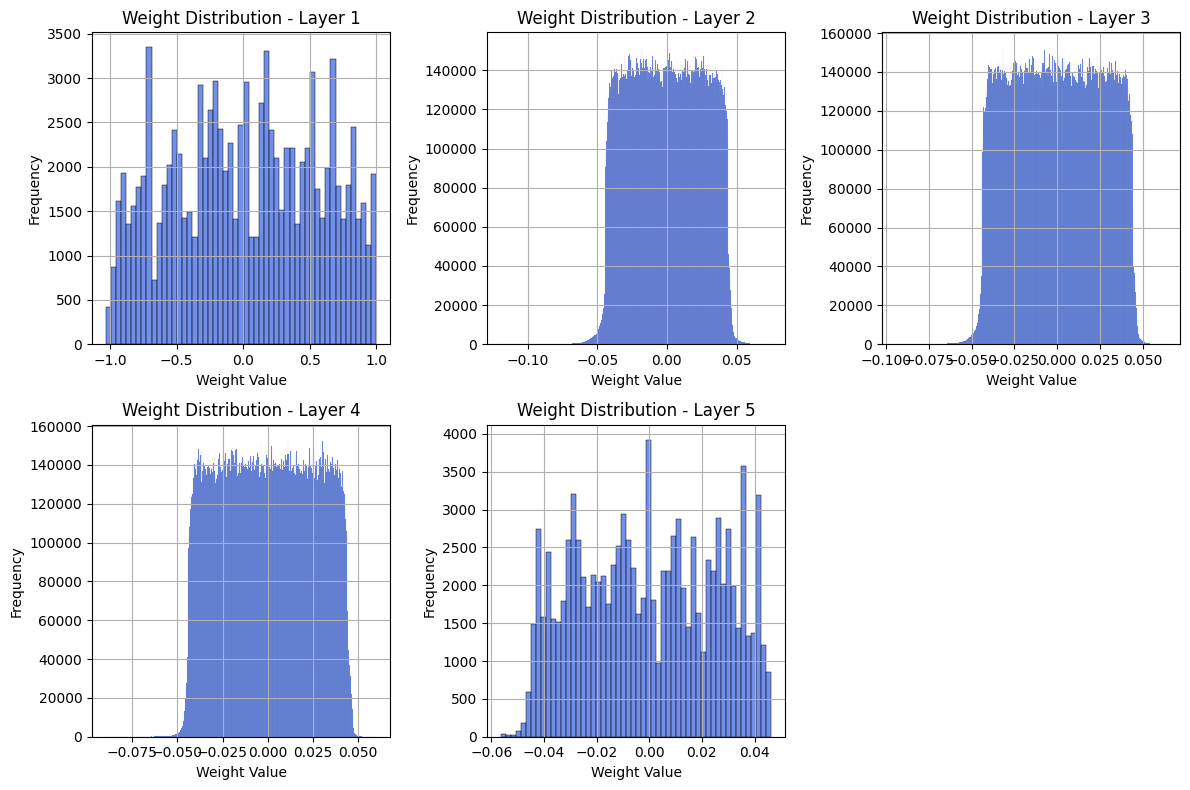

In [ ]:
# List of weight files
weight_files = ["cleaned_L2_weights1.csv", "cleaned_L2_weights2.csv", "cleaned_L2_weights3.csv",
                "cleaned_L2_weights4.csv", "cleaned_L2_weightsout.csv"]

plt.figure(figsize=(12, 8))

# Loop through the weight files and plot each weight distribution in a separate subplot
for i, file in enumerate(weight_files):
    plt.subplot(2, 3, i+1)  # 2 rows, 3 columns, and current plot index

    weights = np.genfromtxt(file, delimiter=',')[:, 1:].flatten()

    sns.histplot(weights, kde=False, color="royalblue")

    # Add labels and title for each subplot
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.title(f"Weight Distribution - Layer {i+1}")
    plt.grid(True)

# Adjust layout to avoid overlap of labels/titles
plt.tight_layout()

# Show the final figure with all subplots
plt.show()


##Learn by Calibration network testing
###

In [ ]:


# Load the diamonds dataset
diamonds = sns.load_dataset("diamonds")
dataset_size = 5000
xy = diamonds[["carat", "price"]].values
np.random.shuffle(xy)  # Shuffle the data
xy = xy[:dataset_size]

# Normalize the data
mean = np.mean(xy, axis=0)
std = np.std(xy, axis=0)
xy_normalized = (xy - mean) / std

# Split the data
train_size = int(0.8 * dataset_size)
train_xy, test_xy = xy_normalized[:train_size], xy_normalized[train_size:]

# Convert to PyTorch tensors
train_x = torch.tensor(train_xy[:, 0], dtype=torch.float32).view(-1, 1)
train_y = torch.tensor(train_xy[:, 1], dtype=torch.float32).view(-1, 1)
test_x = torch.tensor(test_xy[:, 0], dtype=torch.float32).view(-1, 1)
test_y = torch.tensor(test_xy[:, 1], dtype=torch.float32).view(-1, 1)

# Define the Predictor and Interval Estimator Networks

class Predictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 32)
        self.fc_out = nn.Linear(32, 1)  # Final prediction layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        return self.fc_out(x)

class IntervalEstimator(nn.Module):
    def __init__(self, num_alpha=6):  # 6 confidence levels
        super().__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 32)
        self.fc_out = nn.Linear(32, num_alpha * 2)  # Output (δ_l, δ_u) for each α

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))

        bounds = self.fc_out(x)  # Output shape, which is just: (batch_size, num_alpha * 2)

        lower = bounds[:, ::2]  # Extract lower bounds
        upper = lower + torch.nn.functional.softplus(bounds[:, 1::2])

        return lower, upper


# Lg
def calibration_loss(y_true, delta_l, delta_u, alpha, f_pred, lambda1=0.05, lambda2=0.05):
    indicator = ((y_true >= delta_l) & (y_true <= delta_u)).float()

    term1 = torch.abs(alpha - indicator.mean())
    term2 = lambda1 * torch.abs(y_true - (f_pred - delta_l))
    term3 = lambda2 * torch.abs((f_pred + delta_u) - y_true)

    return (term1 + term2 + term3).mean()


#hinge loss function Lf
def hinge_loss(y_true, delta_l, delta_u, f_pred, gamma=0.05):

    loss = torch.max(torch.tensor(0.0), (f_pred-delta_l) - y_true + gamma) + torch.max(torch.tensor(0.0), y_true -  (f_pred+delta_u)+ gamma)

    return loss.mean()

# Initialize models
predictor = Predictor()
interval_estimator = IntervalEstimator()

# Adam optimizer parameters
learning_rate_pred = 1e-5
learning_rate_interval = 1e-4
epochs = 2500
batch_size = 32
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Define Mean Squared Error loss function
def mse_loss(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)

LbC_weights = {f"fc{i+1}": [] for i in range(6)}
LbC_weights["fc_out"] = []

LbC_biases = {f"fc{i+1}": [] for i in range(6)}
LbC_biases["fc_out"] = []

def adam_optimization():
    optimizer_pred = optim.Adam(predictor.parameters(), lr=learning_rate_pred)
    optimizer_interval = optim.Adam(interval_estimator.parameters(), lr=learning_rate_interval)

    alphas = torch.tensor([0.1, 0.3, 0.5, 0.7, 0.9, 0.99])  #Confidence levels
    n = len(train_x)

    for epoch in range(epochs):
        indices = np.random.permutation(n)
        train_x_shuffled = train_x[indices]
        train_y_shuffled = train_y[indices]

        for j in range(0, n, batch_size):
            x_batch = train_x_shuffled[j:j + batch_size]
            y_batch = train_y_shuffled[j:j + batch_size]

            # ---- Train the Predictor for 2 epochs ----
            for _ in range(2):
                optimizer_pred.zero_grad()

                # Forward pass
                y_pred = predictor(x_batch)
                delta_l, delta_u = interval_estimator(x_batch)

                # Sample α for this batch
                alpha_idx = torch.randint(0, len(alphas), (1,)).item()
                alpha = alphas[alpha_idx]

                hinge_loss_val = hinge_loss(y_batch, delta_l[:, alpha_idx], delta_u[:, alpha_idx], y_pred)
                hinge_loss_val.backward()
                optimizer_pred.step()

            # ---- Train the Interval Estimator for 1 epoch ----
            optimizer_interval.zero_grad()

            # Forward pass
            delta_l, delta_u = interval_estimator(x_batch)
            calibration_loss_val = calibration_loss(y_batch, delta_l[:, alpha_idx], delta_u[:, alpha_idx], alpha, y_pred.detach())

            calibration_loss_val.backward()
            optimizer_interval.step()

        # Save Weights & Biases at Each Epoch
        with torch.no_grad():
            for i, layer in enumerate([predictor.fc1, predictor.fc2, predictor.fc3, predictor.fc4, predictor.fc5, predictor.fc_out]):
                LbC_weights[f"fc{i+1}"].append(layer.weight.detach().numpy().tolist())
                LbC_biases[f"fc{i+1}"].append(layer.bias.detach().numpy().tolist())

        # Compute total loss for stopping condition
        y_pred = predictor(train_x)
        current_loss = mse_loss(train_y, y_pred)

        # Log progress
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Training Loss = {current_loss.item():.4f}")


        if epoch >= 500:
            print(f"Training stopped at epoch {epoch}")
            break
        previous_loss = current_loss

        # Implement proper stopping based on calibration error (This was commented out to train for longer)
        #if epoch > 100 and abs(previous_loss - current_loss) < 1e-6:
            #print(f"Training stopped early at epoch {epoch}")
            #break

        previous_loss = current_loss

    # Save Weights & Biases to CSV
    save_dir = "LbC_weights"
    for key in LbC_weights:
        pd.DataFrame(LbC_weights[key]).to_csv(f"{save_dir}/{key}_weights.csv", index=False)
        pd.DataFrame(LbC_biases[key]).to_csv(f"{save_dir}/{key}_biases.csv", index=False)
        print(f"Saved {key} weights & biases to {save_dir}/")

# Start training
adam_optimization()

def evaluate_calibration(test_x, test_y, predictor, interval_estimator):
    alphas = torch.tensor([0.1, 0.3, 0.5, 0.7, 0.9, 0.99])
    delta_l, delta_u = interval_estimator(test_x)
    y_pred = predictor(test_x)

    results = []
    for i, alpha in enumerate(alphas):
        covered = ((test_y >= delta_l[:, i]) & (test_y <= delta_u[:, i])).float().mean().item()
        print(f"Confidence Level {alpha:.2f}: Actual Coverage {covered:.20f}")
        results.append((alpha, covered))

    return results


evaluate_calibration(test_x, test_y, predictor, interval_estimator)

Epoch 0: Training Loss = 0.8647
Epoch 50: Training Loss = 0.1773
Epoch 100: Training Loss = 0.1314
Epoch 150: Training Loss = 0.1328
Epoch 200: Training Loss = 0.1280
Epoch 250: Training Loss = 0.1283
Epoch 300: Training Loss = 0.1292
Epoch 350: Training Loss = 0.1284
Epoch 400: Training Loss = 0.1309
Epoch 450: Training Loss = 0.1285
Epoch 500: Training Loss = 0.1264
Training stopped at epoch 500
Saved fc1 weights & biases to LbC_weights/
Saved fc2 weights & biases to LbC_weights/
Saved fc3 weights & biases to LbC_weights/
Saved fc4 weights & biases to LbC_weights/
Saved fc5 weights & biases to LbC_weights/
Saved fc6 weights & biases to LbC_weights/
Saved fc_out weights & biases to LbC_weights/


In [ ]:
import os

# Define paths
input_dir = "L2weights"
output_dir = "L2weights_cleaned"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# List of weight files inside "L2weights" folder
weight_files = ["fc1_L2_weights.csv", "fc2_L2_weights.csv", "fc3_L2_weights.csv",
                "fc4_L2_weights.csv", "fc5_L2_weights.csv", "fc6_L2_weights.csv"]

for file_name in weight_files:
    input_path = os.path.join(input_dir, file_name)
    output_path = os.path.join(output_dir, f"cleaned_{file_name}")

    # Read and clean the file
    with open(input_path, "r") as file:
        cleaned_lines = [line.replace("[", "").replace("]", "").replace('"', '')
                         for line in file.readlines()[1:]]  # Skip header

    # Convert the cleaned lines into a numpy array
    lbc = np.genfromtxt(cleaned_lines, delimiter=",")

    # Save the cleaned data
    np.savetxt(output_path, lbc, delimiter=",", comments="")

    print(f"Processed {file_name} -> {output_path}, Shape: {lbc.shape}")


Processed fc6_L2_weights.csv -> L2weights_cleaned/cleaned_fc6_L2_weights.csv, Shape: (501, 32)


#Here we plot the distributions for the diamonds dataset

##Note: One must consider the simplistic characteristic nature of the data when interpreting the results. But the toy model provides the skeleton for deeper analysis

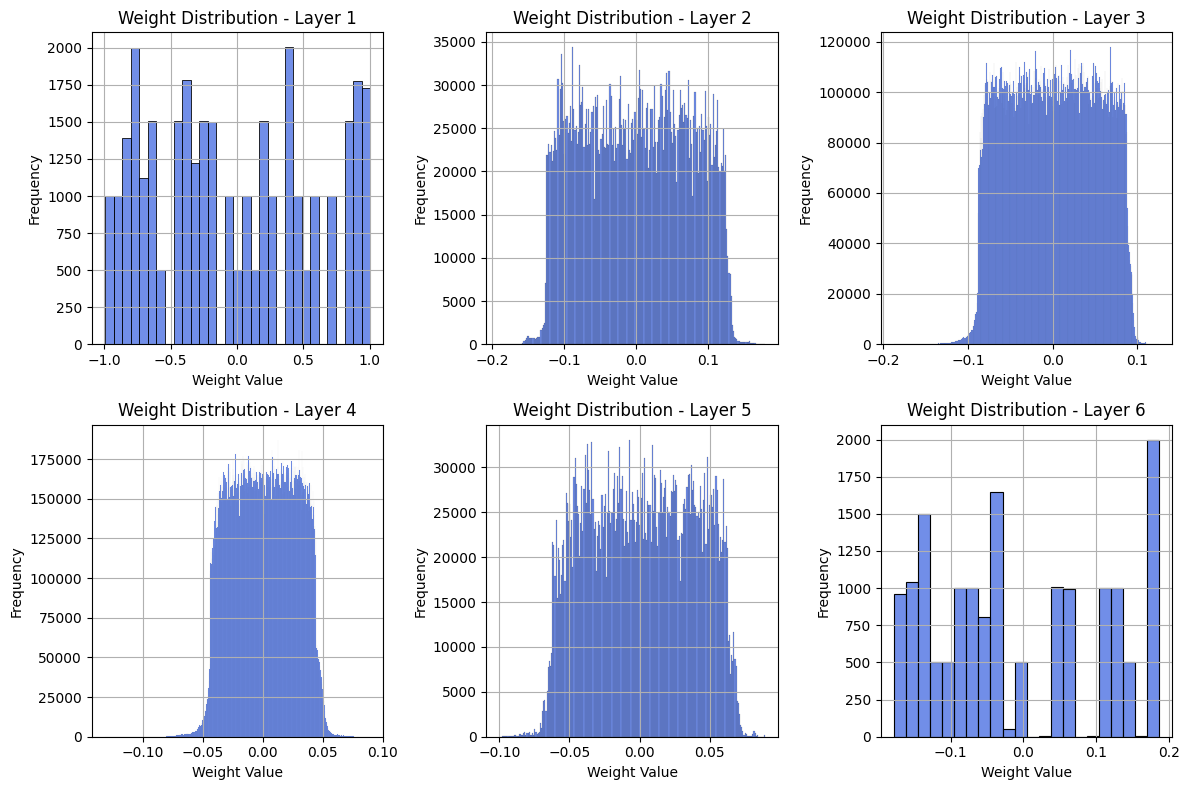

In [ ]:


input_dir = "L2weights_cleaned"

weight_files = ["cleaned_fc1_L2_weights.csv", "cleaned_fc2_L2_weights.csv",
                "cleaned_fc3_L2_weights.csv", "cleaned_fc4_L2_weights.csv",
                "cleaned_fc5_L2_weights.csv", "cleaned_fc6_L2_weights.csv"]

plt.figure(figsize=(12, 8))

for i, file_name in enumerate(weight_files):
    file_path = os.path.join(input_dir, file_name)

    weights = np.genfromtxt(file_path, delimiter=',')[:, :].flatten()


    plt.subplot(2, 3, i+1)
    sns.histplot(weights, kde=False, color="royalblue")


    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.title(f"Weight Distribution - Layer {i+1}")
    plt.grid(True)


plt.tight_layout()


plt.show()


In [ ]:
import os

# Define paths
input_dir = "LbC_weights"
output_dir = "LbCweights_cleaned"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# List of weight files inside "L2weights" folder
weight_files = ["fc1_weights.csv", "fc2_weights.csv", "fc3_weights.csv",
                "fc4_weights.csv", "fc5_weights.csv", "fc6_weights.csv"]

for file_name in weight_files:
    input_path = os.path.join(input_dir, file_name)
    output_path = os.path.join(output_dir, f"cleaned_{file_name}")

    # Read and clean the file
    with open(input_path, "r") as file:
        cleaned_lines = [line.replace("[", "").replace("]", "").replace('"', '')
                         for line in file.readlines()[1:]]  # Skip header

    # Convert the cleaned lines into a numpy array
    lbc = np.genfromtxt(cleaned_lines, delimiter=",")

    # Save the cleaned data
    np.savetxt(output_path, lbc, delimiter=",", comments="")

    print(f"Processed {file_name} -> {output_path}, Shape: {lbc.shape}")


Processed fc1_weights.csv -> LbCweights_cleaned/cleaned_fc1_weights.csv, Shape: (501, 64)
Processed fc2_weights.csv -> LbCweights_cleaned/cleaned_fc2_weights.csv, Shape: (501, 8192)
Processed fc3_weights.csv -> LbCweights_cleaned/cleaned_fc3_weights.csv, Shape: (501, 65536)
Processed fc4_weights.csv -> LbCweights_cleaned/cleaned_fc4_weights.csv, Shape: (501, 131072)
Processed fc5_weights.csv -> LbCweights_cleaned/cleaned_fc5_weights.csv, Shape: (501, 8192)
Processed fc6_weights.csv -> LbCweights_cleaned/cleaned_fc6_weights.csv, Shape: (501, 32)


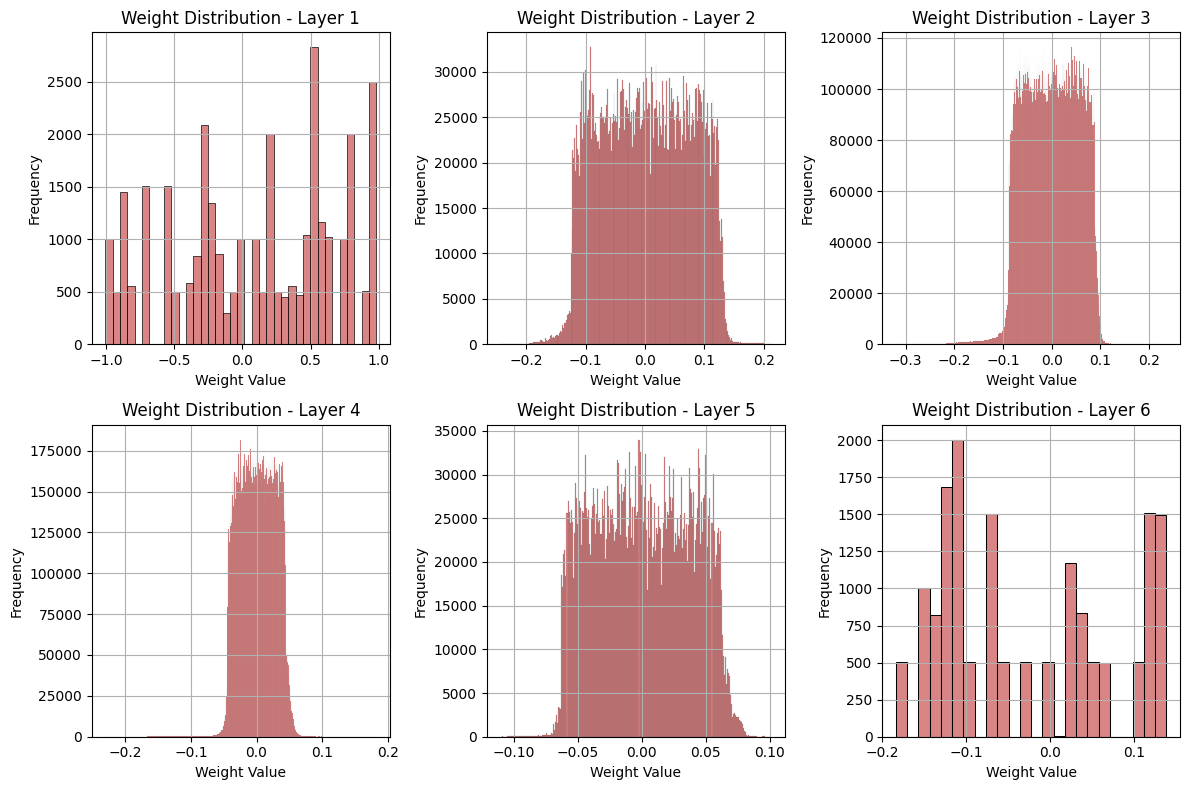

In [ ]:


input_dir = "LbCweights_cleaned"

weight_files = ["cleaned_fc1_weights.csv", "cleaned_fc2_weights.csv",
                "cleaned_fc3_weights.csv", "cleaned_fc4_weights.csv",
                "cleaned_fc5_weights.csv", "cleaned_fc6_weights.csv"]

plt.figure(figsize=(12, 8))

for i, file_name in enumerate(weight_files):
    file_path = os.path.join(input_dir, file_name)

    weights = np.genfromtxt(file_path, delimiter=',')[:, :].flatten()


    plt.subplot(2, 3, i+1)
    sns.histplot(weights, kde=False, color="indianred")


    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.title(f"Weight Distribution - Layer {i+1}")
    plt.grid(True)


plt.tight_layout()


plt.show()


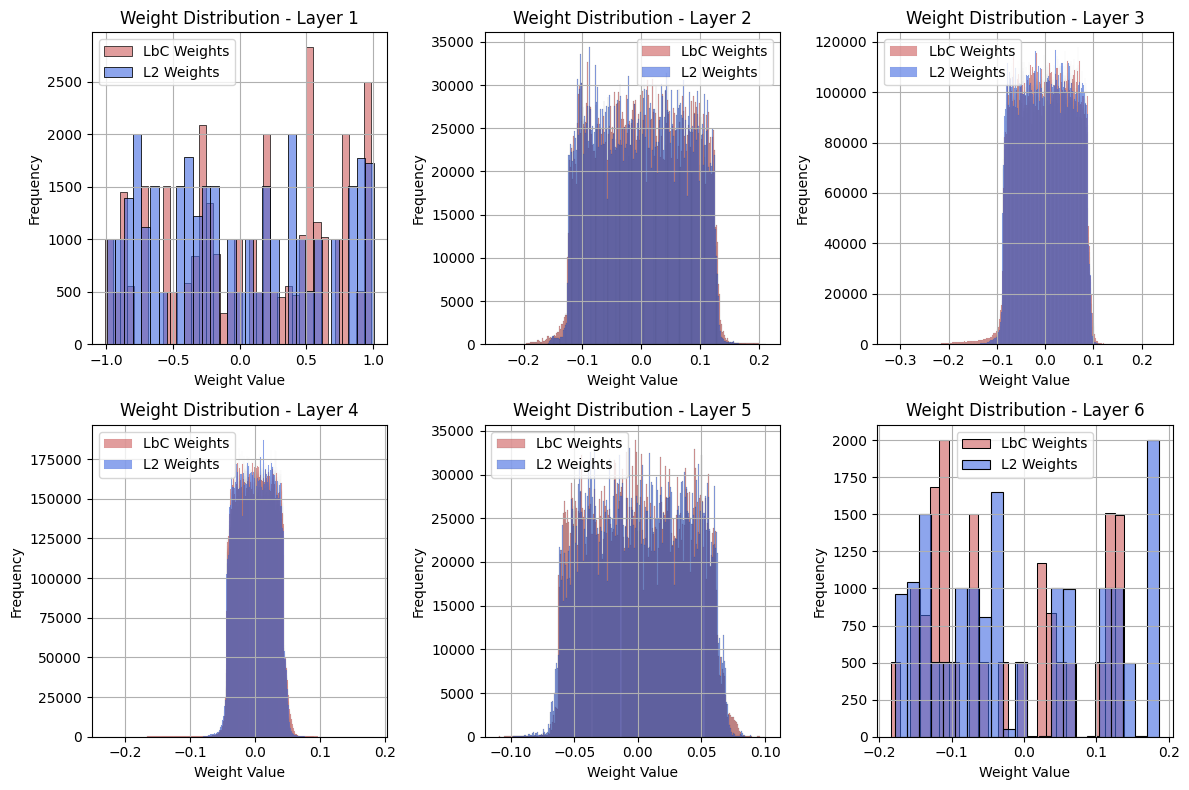

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define directories for cleaned weight files
lbc_dir = "LbCweights_cleaned"
l2_dir = "L2weights_cleaned"

# Define corresponding cleaned weight files
weight_files = ["cleaned_fc1_weights.csv", "cleaned_fc2_weights.csv",
                "cleaned_fc3_weights.csv", "cleaned_fc4_weights.csv",
                "cleaned_fc5_weights.csv", "cleaned_fc6_weights.csv"]  # fc6 -> fc_out

plt.figure(figsize=(12, 8))

# Loop through weight files and overplot distributions
for i, file_name in enumerate(weight_files):
    lbc_path = os.path.join(lbc_dir, file_name)
    l2_path = os.path.join(l2_dir, file_name.replace("_weights", "_L2_weights"))  # Match L2 naming

    # Load weight data
    lbc_weights = np.genfromtxt(lbc_path, delimiter=',')[:, :].flatten()
    l2_weights = np.genfromtxt(l2_path, delimiter=',')[:, :].flatten()

    # Create subplot
    plt.subplot(2, 3, i+1)

    # Plot LbC weight distribution
    sns.histplot(lbc_weights, kde=False, color="indianred", label="LbC Weights", alpha=0.6)

    # Plot L2 weight distribution
    sns.histplot(l2_weights, kde=False, color="royalblue", label="L2 Weights", alpha=0.6)

    # Labels and title
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.title(f"Weight Distribution - Layer {i+1}")
    plt.grid(True)
    plt.legend()

# Adjust layout to avoid overlap of labels/titles
plt.tight_layout()

# Show final figure with overplotted histograms
plt.show()


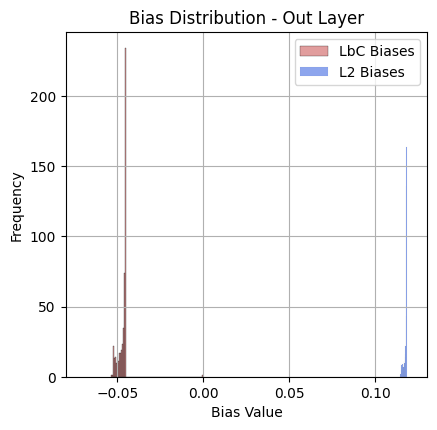

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define directories for cleaned bias files
lbc_dir = "LbC_weights"
l2_dir = "L2weights"

# Define corresponding cleaned bias files
bias_files = ["fc6_biases.csv"]

plt.figure(figsize=(12, 8))

# Loop through bias files and overplot distributions
for i, file_name in enumerate(bias_files):
    lbc_path = os.path.join(lbc_dir, file_name)
    l2_path = os.path.join(l2_dir, file_name.replace("_biases", "_L2_biases"))  # Match L2 naming

    # Load bias data (rows = epochs, columns = biases per node)
    lbc_biases = np.genfromtxt(lbc_path, delimiter=',').flatten()
    l2_biases = np.genfromtxt(l2_path, delimiter=',').flatten()

    # Create subplot
    plt.subplot(2, 3, i+1)

    # Plot LbC bias distribution
    sns.histplot(lbc_biases, kde=False, color="indianred", label="LbC Biases", alpha=0.6)

    # Plot L2 bias distribution
    sns.histplot(l2_biases, kde=False, color="royalblue", label="L2 Biases", alpha=0.6)

    # Labels and title
    plt.xlabel("Bias Value")
    plt.ylabel("Frequency")
    plt.xlim(-0.08,0.13)

    plt.title(f"Bias Distribution - Out Layer")
    plt.grid(True)
    plt.legend()

# Adjust layout to avoid overlap of labels/titles
plt.tight_layout()

# Show final figure with overplotted histograms
plt.show()
